In [1]:
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
from datasets import load_dataset
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

/home/yinghao.luo@mydre.org/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset("json", data_files="dataset/ner_data.json", split="train")

In [ ]:
def extract_entity_spans(dataset, target="PROC"):
    spans = []
    for example in dataset:
        tokens = example["words"]
        labels = example["ner_tags"]
        span = []
        for token, label in zip(tokens, labels):
            if label == f"B-{target}":
                if span:
                    spans.append(" ".join(span))
                span = [token]
            elif label == f"I-{target}" and span:
                span.append(token)
            else:
                if span:
                    spans.append(" ".join(span))
                    span = []
        if span:
            spans.append(" ".join(span))
    return spans

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state
    mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * mask_expanded, dim=1)
    sum_mask = torch.clamp(mask_expanded.sum(dim=1), min=1e-9)
    return sum_embeddings / sum_mask

def get_span_embeddings(span_list, model_path, batch_size=32):
    print(f"[INFO] Extracting from: {model_path}")
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModel.from_pretrained(model_path)
    model.eval()

    all_embeddings = []
    for i in range(0, len(span_list), batch_size):
        batch = span_list[i:i+batch_size]
        encoded = tokenizer(batch, padding=True, truncation=True, return_tensors="pt")
        with torch.no_grad():
            output = model(**encoded)
        pooled = mean_pooling(output, encoded["attention_mask"])
        all_embeddings.append(pooled.cpu())
    return torch.cat(all_embeddings, dim=0).numpy()

def average_intra_similarity(vectors):
    sim_matrix = cosine_similarity(vectors)
    upper_tri_indices = np.triu_indices_from(sim_matrix, k=1)
    sims = sim_matrix[upper_tri_indices]
    return np.mean(sims) if len(sims) > 0 else np.nan

def plot_intra_similarity_distribution(vectors, label):
    sim_matrix = cosine_similarity(vectors)
    sims = sim_matrix[np.triu_indices_from(sim_matrix, k=1)]
    plt.figure(figsize=(6, 4))
    sns.histplot(sims, bins=50, kde=True)
    plt.title(f"Intra Similarity Distribution: {label}")
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Frequency")
    plt.show()


proc_spans = extract_entity_spans(dataset, target="PROC")
chem_spans = extract_entity_spans(dataset, target="CHEM")
diso_spans = extract_entity_spans(dataset, target="DISO")
anat_spans = extract_entity_spans(dataset, target="ANAT")



In [4]:
model_paths = {
    "mBERT": "mbert",
}

results = []

for name, path in model_paths.items():
    diso_vecs = get_span_embeddings(diso_spans, path)
    anat_vecs = get_span_embeddings(anat_spans, path)
    chem_vecs = get_span_embeddings(chem_spans, path)
    proc_vecs = get_span_embeddings(proc_spans, path)
    diso_sim = average_intra_similarity(diso_vecs)
    anat_sim = average_intra_similarity(anat_vecs)
    chem_sim = average_intra_similarity(chem_vecs)
    proc_sim = average_intra_similarity(proc_vecs)
    results.append({"Model": name, "DISO_intra_similarity": diso_sim, "CHEM_intra_similarity": chem_sim, "ANAT_intra_similarity": anat_sim,"PROC_intra_similarity": proc_sim})

df = pd.DataFrame(results)
display(df)


[INFO] Extracting from: mbert


Some weights of BertModel were not initialized from the model checkpoint at mbert and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertModel were not initialized from the model checkpoint at mbert and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[INFO] Extracting from: mbert


Some weights of BertModel were not initialized from the model checkpoint at mbert and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[INFO] Extracting from: mbert


Some weights of BertModel were not initialized from the model checkpoint at mbert and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[INFO] Extracting from: mbert


,Model,DISO_intra_similarity,CHEM_intra_similarity,ANAT_intra_similarity,PROC_intra_similarity
0,mBERT,0.462294,0.501751,0.493379,0.460931


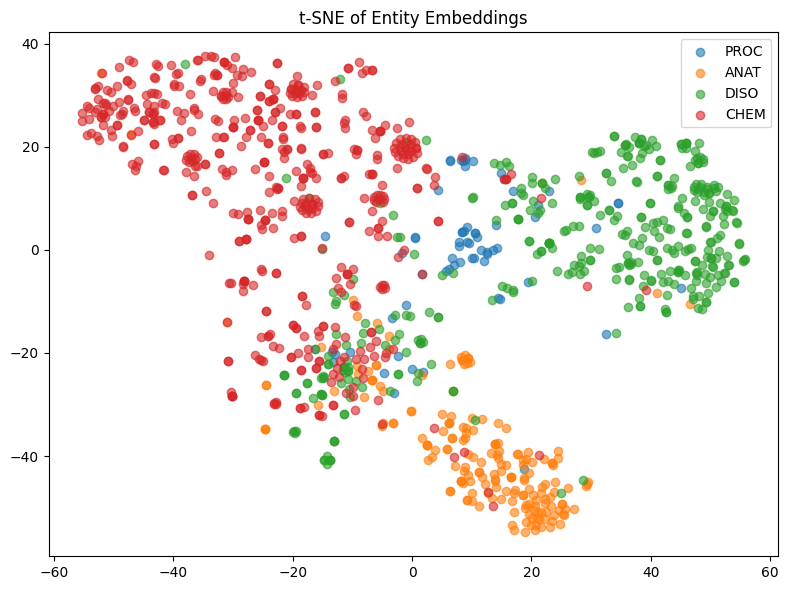

In [5]:
X = np.concatenate([proc_vecs, chem_vecs, diso_vecs, anat_vecs])
y = (["PROC"] * len(proc_vecs)) + (["CHEM"] * len(chem_vecs)) + (["DISO"] * len(diso_vecs)) + (["ANAT"] * len(anat_vecs))
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X)

plt.figure(figsize=(8, 6))
for label in set(y):
    idxs = [i for i, l in enumerate(y) if l == label]
    plt.scatter(X_2d[idxs, 0], X_2d[idxs, 1], label=label, alpha=0.6)
plt.legend()
plt.title("t-SNE of Entity Embeddings")
plt.tight_layout()
plt.savefig("tsne_ro_ner.png", dpi = 300, facecolor = "white")
plt.show()


In [6]:
model_paths = {
    "mBERT-ro-bio": "mbert-ro-bio"
}

results = []

for name, path in model_paths.items():
    diso_vecs = get_span_embeddings(diso_spans, path)
    anat_vecs = get_span_embeddings(anat_spans, path)
    chem_vecs = get_span_embeddings(chem_spans, path)
    proc_vecs = get_span_embeddings(proc_spans, path)
    diso_sim = average_intra_similarity(diso_vecs)
    anat_sim = average_intra_similarity(anat_vecs)
    chem_sim = average_intra_similarity(chem_vecs)
    proc_sim = average_intra_similarity(proc_vecs)
    results.append({"Model": name, "DISO_intra_similarity": diso_sim, "CHEM_intra_similarity": chem_sim, "ANAT_intra_similarity": anat_sim,"PROC_intra_similarity": proc_sim})
    
    # plot_intra_similarity_distribution(vecs, label=name)

df = pd.DataFrame(results)
# df = df.sort_values("DISO_intra_similarity", ascending=False)
display(df)

Some weights of BertModel were not initialized from the model checkpoint at mbert-ro-bio and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[INFO] Extracting from: mbert-ro-bio


Some weights of BertModel were not initialized from the model checkpoint at mbert-ro-bio and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[INFO] Extracting from: mbert-ro-bio


Some weights of BertModel were not initialized from the model checkpoint at mbert-ro-bio and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[INFO] Extracting from: mbert-ro-bio


Some weights of BertModel were not initialized from the model checkpoint at mbert-ro-bio and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[INFO] Extracting from: mbert-ro-bio


,Model,DISO_intra_similarity,CHEM_intra_similarity,ANAT_intra_similarity,PROC_intra_similarity
0,mBERT-ro-bio,0.603394,0.521919,0.600404,0.543961
